# Representing and comparing probabilities with kernels - practical

Notebook prepared by [Heiko Strathmann](http://herrstrathmann.de/) with additional code by [Dougal Sutherland](http://www.gatsby.ucl.ac.uk/~dougals/) and Kacper Chwialkowski.
Feel free to email any questions you have.

In this notebook, we will cover implementation details and applications for three types of kernel hypothesis tests:
    
* Two-sampling testing using the Maximum Mean Discrepancy (MMD)
* Independence testing using the Hilbert-Schmidt Independence Criterion (HSIC)
* Goodness-of-fit testing using the Kernel Stein Discrepancy (KSD)

On the fly, we will introduce basic concepts of statistical hypothesis testing.

The notebook contains a number of `# IMPLEMENT` comments, where you are supposed to insert missing code yourself.
We also prepared a solution notebook that contains the code we envisioned.

Cells are meant to be executed in order (i.e. cells might depend on previous ones).

## Dependencies
The notebook was written using Python 3.6, but we made an effort to keep it backwards compatible to older versions down to 2.7 (hopefully).

We encourage you to use a `conda` environment so you don't modify your system's Python setup (especially due to the problems that come with install TensorFlow and Shogun).

The packages you need are:
* A standard scipy setup covers most content: `numpy`, `scipy`, `matplotlib`, and of yource `jupyter`
* `tensorflow` for gradient-based optimization of test power on the MNIST-GAN example. Note we recommend to install this using `conda install -c conda-forge tensorflow `
* Optional: `scikit-learn` for a cross-validation splitting iterator (can implement yourself or use another lib)
* Optional: `seaborn`, `pandas` for convenient visualization in some examples
* Optional: `tqdm` for a fancy progress bar
* Optional: Shogun if you want to run a faster MMD test in the MNIST-GAN example: `conda install -c conda-forge shogun` (do this first as the package currently uses openblas and not MKL, so some of the other packages need to be re-installed).

This is an example how to set this environment up and run the notebook server
```
conda create --name ds3_kernels  python=3.6
source activate ds3_kernels
conda install -c conda-forge tensorflow 
conda install -c conda-forge shogun
conda install jupyter matplotlib scikit-learn seaborn pandas tqdm
jupyter notebook
```

See the Anaconda/TensorFlow/Shogun installation pages for more details.


## Additional files
All files can be found at https://github.com/karlnapf/ds3_kernel_testing.
They include

* This notebook and the solution notebook (we encourage you to not look at this before the practical has finished).
* **Provided Python modules**: We provide a few external modules that need to be in the `PYTHONPATH` of your notebook server (just put the files in the same folder as this notebook and start the server from this folder).
To see whether this worked, try ```import mmd```, and if it doesn't work, make sure that the file is present in one of the paths when you execute `import sys; print(sys.path)`.
* **Provided data**: Put those into the same folder as this notebook

In [60]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
    from tqdm import tqdm_notebooks as tqdm
except ImportError:
    tqdm = lambda x: x

# Two-sample testing

Let us begin with some simple data $X\sim P_X, Y\sim P_Y$.

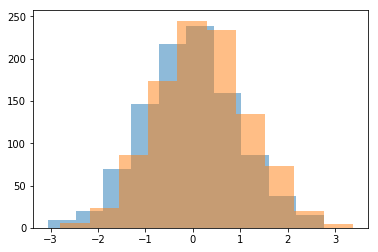

In [8]:
data = np.load("simple.npz")
X = data["X"]
Y = data["Y"]
plt.hist(X, alpha=0.5)
plt.hist(Y, alpha=0.5);

Question: do X and Y come from the same distribution?
Or in other words: can we reject the null hypothesis that $P_X=P_Y$?

## The simplest of all test statistics

Let's start by comparing the means of the samples.
Clearly, if the distributions are the same, the mean would be zero.

In [9]:
def simple_statistic(X,Y, squared=False):
    assert X.ndim == Y.ndim == 1
    
    # IMPLEMENT: compute mean difference of X and Y
    result = 
    
    if squared:
        result *= result
    return result

my_statistic = simple_statistic(X,Y)
print("Mean differencce:", my_statistic)

Mean differencce: -0.25887364


Significant?
What would it be if distributions were the same? What if they were different?

Let's assume that $P_X=P_Y$ and look at the distribution of the test statistic (null distribution).
For that, we can merge the samples and shuffle them, after which they have the same "joint" distribution.
We can then re-compute the statistic for multiple permutations to get a feeling for how the statistic is distributed.

In [10]:
def two_sample_permutation_test(test_statistic, X, Y, num_permutations, prog_bar=True):
    assert X.ndim == Y.ndim
    
    statistics = np.zeros(num_permutations)
    
    range_ = range(num_permutations)
    if prog_bar:
        range_ = tqdm(range_)
    for i in range_:
        # concatenate samples
        if X.ndim == 1:
            Z = np.hstack((X,Y))
        elif X.ndim == 2:
            Z = np.vstack((X,Y))
            
        # IMPLEMENT: permute samples and compute test statistic
        
        my_test_statistic = 
        statistics[i] = my_test_statistic
    return statistics

num_permutations = 200
statistics = two_sample_permutation_test(simple_statistic, X, Y, num_permutations)

Now we have an idea about what to expect from the statistic in case where the distributions are equal.
How likely is our particular value of that statistic?
We can compare it against the say 95% quantiles of the null distribution.
If our statistic lies outside those, we can reject the null with a confidence of 0.05.

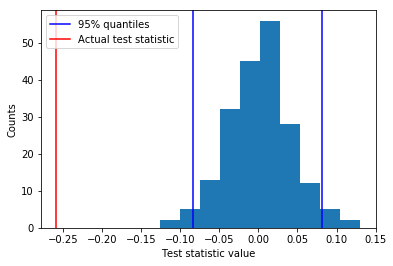

In [11]:
def plot_permutation_samples(null_samples, statistic=None):
    plt.hist(null_samples)
    plt.axvline(x=np.percentile(null_samples, 2.5), c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic, c='r')
        legend += ["Actual test statistic"]
    plt.legend(legend)
    plt.axvline(x=np.percentile(null_samples, 97.5), c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")
    
plot_permutation_samples(statistics, my_statistic)

Note that, depending on the test statistic, there might be multiple ways to compute the null distribution.
Not all of them work via sampling it directly, which also can be costly.
For example, if we just use the mean difference as a test statistic, and then plug in two Gaussian distributed random variables, we know that the distribution of the statistic is also Gaussian (see the above plot). 
We might be even able to analytically work out the parameters of this distribution.

In case you haven't realized, this is basically a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) where we assume that we know that both distributions have unit variance and we can distinguish them via solely looking at their mean.
As it will be useful for kernel based test statistics later, we will also look at the distribution of a squared test statistic, in order to make it strictly positive (and zero in expectation if both distributions are the same).
Naturally, the average of squared Gaussian random variables has a chi-square distribution -- something that can be used for the kernel tests that we introduce later.

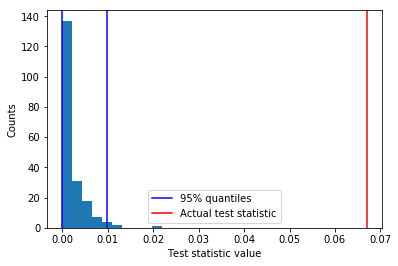

In [12]:
# IMPLEMENT: use squared test statistic
simple_statistic_squared = 

# visualise test
statistics = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y)
plot_permutation_samples(statistics, my_statistic)

### Alternative distribution via explicit simulation

As a caveat, please note that the test statistic itself has a distribution under the alternative hypothesis ($P_X \neq P_Y$), and that our computed test statistic is only a single sample from this distribution.
In practice, it is unfortunately not possible to look at the distribution of the test under the alternative, as this would require a way to generate more data.
We can try this for a synthetic example where we have infinite data though.

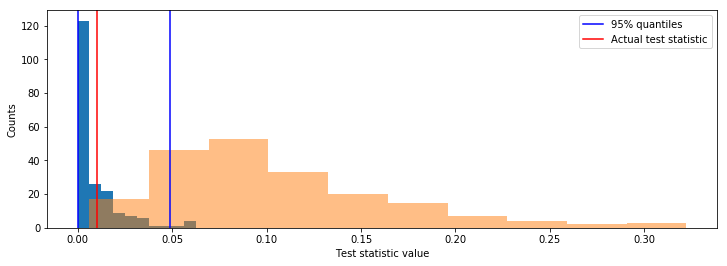

In [13]:
np.random.seed(0)

# we make a model where the null distribution is false
shift = .3
N = 200
X = np.random.randn(N)
Y = np.random.randn(N)+shift

statistics_null = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y) # this is a single sample from the alternative

statistics_alt = np.zeros(num_permutations)
for i in tqdm(range(num_permutations)):
    # IMPLEMENT: generate more data from the alternative
    X = 
    Y =  
    
    statistics_alt[i] = simple_statistic_squared(X,Y)
    
plt.figure(figsize=(12,4))
plot_permutation_samples(statistics_null, my_statistic)    
plt.hist(statistics_alt, alpha=0.5);

As you can see, even though most of the alternative distribution far larger than the null, we can be unlucky: there are datasets for which the test would not reject the null simply by chance -- we only have a single draw from the alternative.
With this fixed seed, it turns out that we have been unlucky and would have not rejected the null hypothesis even it is not true.
You could play with the sample size and observe how this impacts the position of the alternative distribution (and as such the test power).

Let's try the test on another dataset.

Means: -0.05499658 0.027213123
Standard deviations: 1.046988 0.9609663


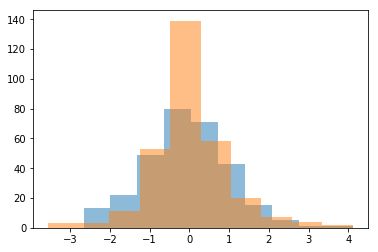

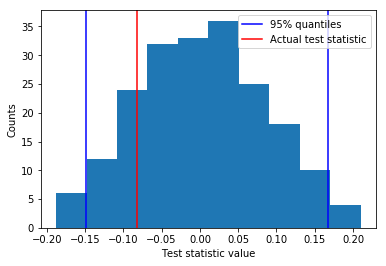

In [14]:
data = np.load("almost_simple.npz")
X = data["X"]
Y = data["Y"]
plt.hist(X, alpha=0.5)
plt.hist(Y, alpha=0.5)

# IMPLEMENT: print mean and std deviation of data
print()

my_statistic = simple_statistic(X,Y)
statistics = two_sample_permutation_test(simple_statistic, X, Y, num_permutations)

plt.figure()
plot_permutation_samples(statistics, my_statistic)

And now for the squared test statistic

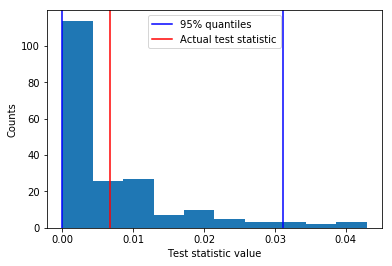

In [15]:
# IMPLEMENT: visualize test for squared statistic
simple_statistic_squared = 
statistics = 
my_statistic = 
plot_permutation_samples(statistics, my_statistic)

As we can see, both test statistics essentially have no chance in distinguishing this data.
(althogh keep in mind we could have been unlucky as outlined above).
For now, let's just assume we only have a single dataset to compute the test.

## Quadratic time MMD



We have already seen the quadratic time MMD: it was the squared difference of the sample means above, if we had used a linear kernel (where the feature space embedding is the identity function).
This test wasn't able to distinguish the above distributions, but let's try a different kernel.

We will use the unbiased statistic here, defined as
$$ 
\frac{1}{n(n-1)}\sum_{i=1}^n\sum_{j\neq i}^m k(x_i,x_j) + \frac{1}{m(m-1)}\sum_{i=1}^n\sum_{j\neq i}^mk(y_i,y_j) -2\frac{1}{nm}\sum_{i=1}^n \sum_{j=1}^m k(x_i,y_j)
$$
See the slides for more details.

### Kernels


We first need to implement a kernel function.
Though we could use a framework to do this for us, it is quite instructive to do this ourselves (at least once).

We will start with a Gaussian kernel
$$
k(x,y) = \exp \left( - \frac{||x-y||_2^2}{\sigma}\right)
$$
with some bandwidth parameter $\sigma$ (note there are many different parametrizations!).

This kernel is translation invariant, and like many other kernels, it is defined in terms of pairwise (Euclidean) distances between the data.
Let's implement it this way so we can easily try other kernels that are translation invariant.

In [16]:
from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = 
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = 

    return sq_dists

def gauss_kernel(X, Y=None, sigma=1.0):
    """
    Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))

    X - 2d array, samples on left hand side
    Y - 2d array, samples on right hand side, can be None in which case they are replaced by X
    
    returns: kernel matrix
    """

    # IMPLEMENT: compute squared distances and kernel matrix
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# IMPLEMENT
def linear_kernel(X, Y):
    return np.dot(X, Y.T)

With the kernel at hand, we can implement the quadratic time MMD statistic as a function of the kernel.

In [17]:
def quadratic_time_mmd(X,Y,kernel):
    assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)
       
    n = len(K_XX)
    m = len(K_YY)
    
    # IMPLEMENT: unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    mmd = 
    return mmd

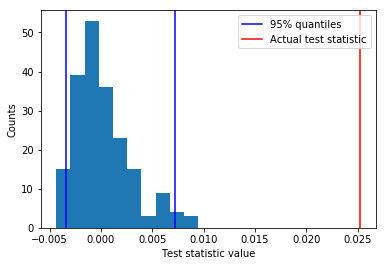

In [18]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.3)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

This seems much better: the Gaussian kernel allows us to very clearly distinguish the two distributions.

Now let us try the MMD with a linear kernel and compare it to the above.
In particular, compare (and think about) the relationship to the simple squared mean difference statistic we computed above.

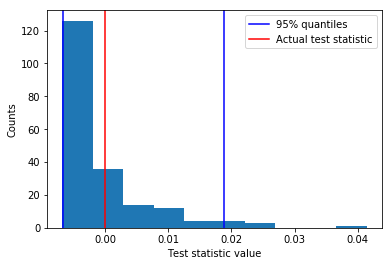

In [19]:
# IMPLEMENT: visualize test using linear kernel
